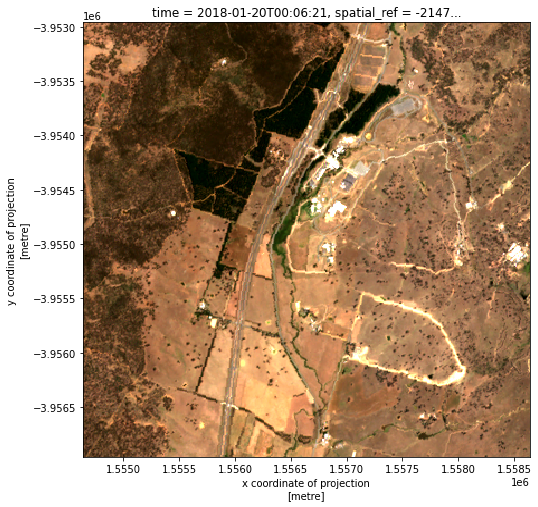

In [48]:
%matplotlib inline

import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
from skimage import morphology

#clean_raw_011_005_2018-01-20.png
j = 12
i = 5

f"/data/pca_act/{26*j+i:03d}_2018.nc",\
f"/data/pca_act/tiles/clean_{j:03d}_{i:03d}_2018-01-20.png"

def buffer_nans(da, kn):
    k = np.zeros((kn,kn))
    k[kn//2,kn//2] = 1

    arr = da.values
    mask = np.ones(arr.shape).astype(np.float32)

    for i in range(arr.shape[0]):
        mask[i,:,:] = signal.convolve2d(arr[i,:,:], k, boundary='fill', mode='same')

    return da.where(~np.isnan(mask))

def generate_blue_mask(ds):
    blue = ds.nbart_blue.astype(np.float32) / 1e4

    # 1.- Create mask for reflectances with deviations more than 0.07 from lower quartile
    qmask = ((blue - blue.quantile(0.25, dim='time'))>.07).values

    # 2.- Remove small objects (< 36 pixels)
    for i in range(qmask.shape[0]):
        qmask[i] = morphology.remove_small_objects(qmask[i], 36)
        
    blue = blue.where(~qmask)

    # 3.- Grow a 9x9 buffer around NaN pixels 
    blue = buffer_nans(blue, 9)

    # 4.- Discard frames with more than 33% missing pixels
    blue = blue.isel(time=(np.count_nonzero(np.isnan(blue.values), axis=(1,2))/(400*400))<.33)
    
    return blue


ds2018 = xr.open_dataset(f"/data/pca_act/{26*j+i:03d}_2018.nc")
ds2019 = xr.open_dataset(f"/data/pca_act/{26*j+i:03d}_2019.nc")
ds = xr.concat([ds2018, ds2019], dim='time').sortby('time')

blue = generate_blue_mask(ds)

ds[['nbart_red','nbart_green','nbart_blue']].isel(time=2).to_array().plot.imshow(robust=True, figsize=(8, 8))

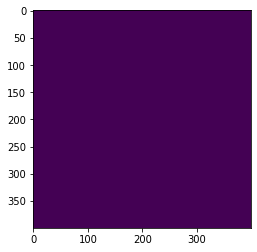

In [34]:
plt.imshow(qmask_f[2])

In [ ]:
pixels = blue.isel(y=147, x=98).values

np.count_nonzero(~np.isnan(pixels))/pixels.size

blue.isel(y=147, x=98).plot()

In [ ]:
blue.isel(y=147, x=98).quantile(.25)

In [ ]:
_ = plt.plot(np.count_nonzero(np.isnan(blue.values), axis=(1,2)))

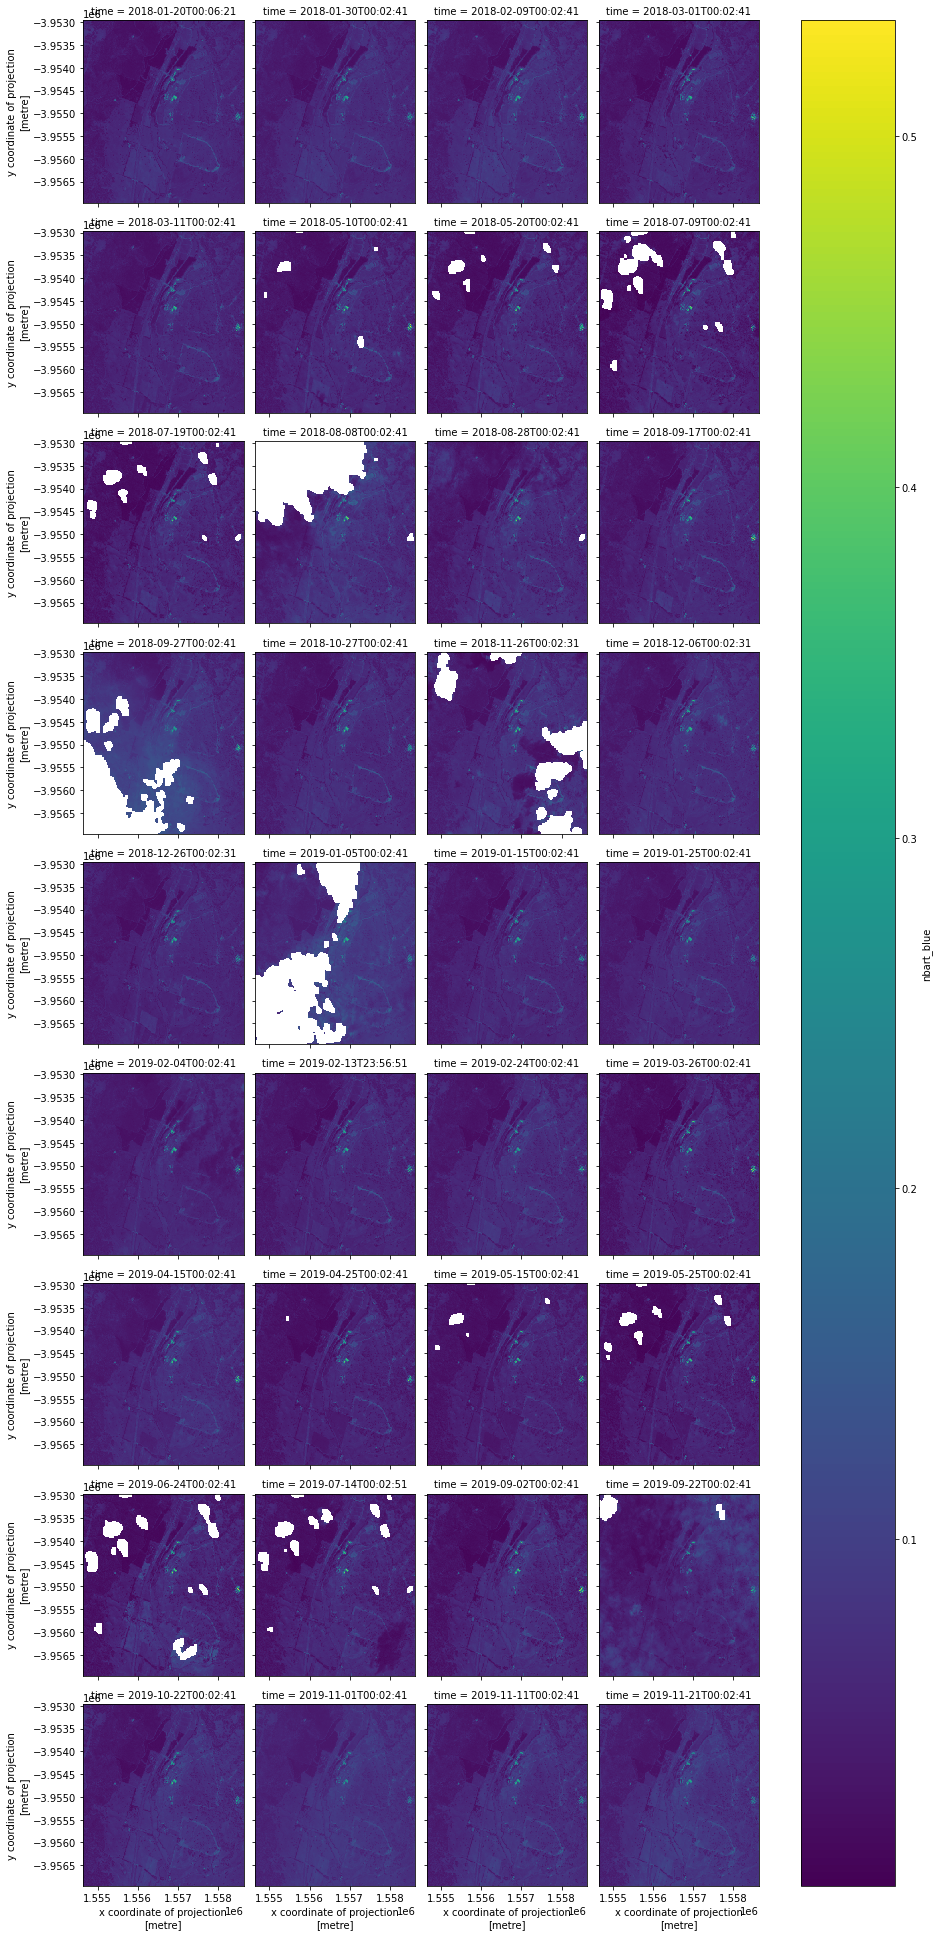

In [49]:
blue.plot(col='time', col_wrap=4)

In [ ]:
np.count_nonzero(np.isnan(blue.values), axis=(1,2))

In [ ]:
blue.isel(y=147, x=98).values

In [ ]:
ax1, ax2 = np.where(np.isnan(blue.isel(time=2, x=slice(0,150)).values))

print(ax1[173], ax2[173])

ax1, ax2



In [ ]:
_ = plt.hist(blue.isel(y=147, x=98).values.flatten(), bins=50)

In [ ]:
blue.isel(time=~np.isnan(blue.isel(y=147, x=98).values)).plot(col='time', col_wrap=6)

In [ ]:
i = 5

blue.isel(time=i, x=slice(0,150)).plot()
blue.isel(time=i, y=ax1[173], x=ax2[173]).values

In [ ]:
plt.imshow(np.isnan(blue.isel(time=2, x=slice(0,150)).values))